In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/Projects')

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!cp /content/gdrive/MyDrive/Datasets/scl-2021-ds.zip /content/
# !cp /content/gdrive/MyDrive/Datasets/scl-2021-ds.zip /content/

In [4]:
import zipfile
 
local_zip = '/content/scl-2021-ds.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
!pip install tensorflow-addons
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 706kB 21.0MB/s 
     |████████████████████████████████| 2.1MB 18.6MB/s 
     |████████████████████████████████| 901kB 55.0MB/s 
     |████████████████████████████████| 3.3MB 53.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=aa8f3f8751bdad9c30f678a81d04ec5937b962fe46534a6ca411974acc381523
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow_addons as tfa
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import tensorflow.keras.optimizers
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

In [7]:
from transformers import BertTokenizer, TFBertModel

model_name='cahya/bert-base-indonesian-522M'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)
text = "Silakan diganti dengan text apa saja."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

Some layers from the model checkpoint at cahya/bert-base-indonesian-522M were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at cahya/bert-base-indonesian-522M.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
dataset = pd.read_csv("/content/train.csv")
dataset

,id,raw_address,POI/street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",/
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru
...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,/jend ahmad yani
299996,299996,"raya cila kko, cilandak timur kel.",/raya cila kko
299997,299997,tanjung gusta jl. yaya 2 no 17,/
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 ...,taman asri/


In [9]:
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian')) 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
dataset['POI'] = dataset['POI/street'].str.extract(r'(.*)/', expand=True)
dataset['street'] = dataset['POI/street'].str.extract(r'/(.*)', expand=True)

In [11]:
dataset

,id,raw_address,POI/street,POI,street
0,0,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",/,,
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung
3,3,"toko dita, kertosono",toko dita/,toko dita,
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru
...,...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,/jend ahmad yani,,jend ahmad yani
299996,299996,"raya cila kko, cilandak timur kel.",/raya cila kko,,raya cila kko
299997,299997,tanjung gusta jl. yaya 2 no 17,/,,
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 rt02 03 no 57.,taman asri/,taman asri,


In [12]:
def find_first_index(ra_split, st_split):
    
    if len(st_split) <= len(ra_split): # new
    
        num_iter = len(ra_split) - len(st_split) + 1
        overlap_list = []

        for i in range(num_iter):
            window = ra_split[i: i+len(st_split)]
            overlap = list(set(window) & set(st_split))
            overlap_list.append(len(overlap))

        max_overlap = [e for e in range(len(overlap_list)) if overlap_list[e] == max(overlap_list)]
        if len(max_overlap) == 1:
            return max_overlap[0]

        else:
            count_list = []
            for idx in max_overlap:
                subset_ra = ra_split[idx: idx+len(st_split)]
                count = 0
                for e in range(len(subset_ra)):
                    if subset_ra[e] not in st_split[e]:
                        count += 0
                    else:
                        count += 1
                count_list.append(count)
            index = count_list.index(max(count_list))
            return max_overlap[index]
    else:
        return 0


def fix_street_errors(row):
    
    raw_add = row['raw_address']

    # If a street name is extracted...
    if row['street'] != "":

        raw_add_split = nltk.tokenize.word_tokenize(raw_add)
        
        extr_street = row['street']
        extr_street_split = nltk.tokenize.word_tokenize(extr_street)
        
        # If the extracted street is in the raw address as an entire string, good!
        if extr_street in raw_add:
            return raw_add
        
        # This is where there are discrepancies!
        else:
            index_in_ra = find_first_index(raw_add_split, extr_street_split)
            raw_add_split[index_in_ra: index_in_ra+len(extr_street_split)] = extr_street_split
            updated_raw_add = ' '.join(raw_add_split).replace(' ,', ',').replace(' .', '.').replace(' )', ')').replace(' (', '(').replace(' ?', '?')          
            return updated_raw_add
      
    # If a street name is originally an empty string, we just assume there's no error. 
    else:
        return raw_add

dataset['cleaned_raw_address'] = dataset.apply(fix_street_errors, axis=1)

In [13]:
def fix_poi_errors(row):
    
    raw_add = row['cleaned_raw_address']

    # If a POI name is extracted...
    if row['POI'] != "":

        raw_add_split = nltk.tokenize.word_tokenize(raw_add)
        
        extr_poi = row['POI']
        extr_poi_split = nltk.tokenize.word_tokenize(extr_poi)
        
        # If the extracted POI is in the raw address as an entire string, good!
        if extr_poi in raw_add:
            return raw_add
        
        # This is where there are discrepancies!
        else:
            index_in_ra = find_first_index(raw_add_split, extr_poi_split)
            raw_add_split[index_in_ra: index_in_ra+len(extr_poi_split)] = extr_poi_split
            updated_raw_add = ' '.join(raw_add_split).replace(' ,', ',').replace(' .', '.').replace(' )', ')').replace(' (', '(').replace(' ?', '?')          
            return updated_raw_add
      
    # If a POI name is originally an empty string, we just assume there's no error. 
    else:
        return raw_add

In [14]:
dataset['cleaned_raw_address'] = dataset.apply(fix_poi_errors, axis=1)
dataset

,id,raw_address,POI/street,POI,street,cleaned_raw_address
0,0,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat
1,1,"aye, jati sampurna",/,,,"aye, jati sampurna"
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,setu siung 119 rt 5 1 13880 cipayung
3,3,"toko dita, kertosono",toko dita/,toko dita,,"toko dita, kertosono"
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru,jl. orde baru
...,...,...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,/jend ahmad yani,,jend ahmad yani,jend ahmad yani 331 kertasari ciamis
299996,299996,"raya cila kko, cilandak timur kel.",/raya cila kko,,raya cila kko,"raya cila kko, cilandak timur kel."
299997,299997,tanjung gusta jl. yaya 2 no 17,/,,,tanjung gusta jl. yaya 2 no 17
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 rt02 03 no 57.,taman asri/,taman asri,,jalan cipadu jaya taman asri gang bijaksana 3 rt02 03 no 57.


#Train

In [15]:
import string

table = str.maketrans('', '', string.punctuation)

tag = []
for index, row in dataset.iterrows():
# for i in dataset['cleaned_raw_address']:
    temp = []
    # addr_elements = nltk.tokenize.word_tokenize(row['cleaned_raw_address']) #i.split()
    # street_element = nltk.tokenize.word_tokenize(row['street'])
    # POI_element = nltk.tokenize.word_tokenize(row['POI'])
    addr_elements = [w.translate(table) for w in row['cleaned_raw_address'].split()]
    # addr_elements = row['cleaned_raw_address'].split()
    street_element = [w.translate(table) for w in row['street'].split()]
    POI_element = [w.translate(table) for w in row['POI'].split()]
    for element in addr_elements:
        if element in street_element:
            temp.append('street')
        elif element in POI_element:
            temp.append('POI')
        else :
            temp.append('O')
    
    tag.append(temp)

dataset['tag'] = tag

In [16]:
import string

table = str.maketrans('', '', string.punctuation)
address_array = []
for index, row in dataset.iterrows():
    stripped = [w.translate(table) for w in row['cleaned_raw_address'].split()]
    address_array.append(stripped)
    
dataset['address_array'] = address_array

In [17]:
# address_array_all = address_array + test_address_array
# df = pd.DataFrame(list(zip(address_array_all)), columns =['address_array'])

In [18]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        # vocab = list(set(dataset['cleaned_raw_address'].to_list()))
        temp = []
        for i in dataset['address_array'].to_list():
            temp.extend(list(set(i)))
        vocab = list(set(temp))
    else:
        # vocab = list(set(dataset['tag'].to_list()))
        temp = []
        for i in dataset['tag'].to_list():
            temp.extend(set(i))
        vocab = list(set(temp))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(dataset, 'token')
tag2idx, idx2tag = get_dict_map(dataset, 'tag')

In [19]:
address_idx = []
for index, row in dataset.iterrows():
    address_idx.append(list(map(token2idx.get, row['address_array'])))

dataset['address_idx'] = address_idx

tag_idx = []
for index, row in dataset.iterrows():
    tag_idx.append(list(map(tag2idx.get, row['tag'])))

dataset['tag_idx'] = tag_idx

In [20]:
dataset

,id,raw_address,POI/street,POI,street,cleaned_raw_address,tag,address_array,address_idx,tag_idx
0,0,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,jl kapuk timur delta sili iii lippo cika 11 a cicau cikarang pusat,"[street, street, street, street, street, street, street, street, O, O, O, O, O]","[jl, kapuk, timur, delta, sili, iii, lippo, cika, 11, a, cicau, cikarang, pusat]","[31044, 32110, 36219, 28097, 7543, 79222, 45197, 93796, 17053, 6871, 52480, 53059, 16535]","[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]"
1,1,"aye, jati sampurna",/,,,"aye, jati sampurna","[O, O, O]","[aye, jati, sampurna]","[67465, 46254, 80815]","[0, 0, 0]"
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,setu siung 119 rt 5 1 13880 cipayung,"[O, street, O, O, O, O, O, O]","[setu, siung, 119, rt, 5, 1, 13880, cipayung]","[53670, 34584, 76412, 66623, 62531, 65292, 51492, 46527]","[0, 2, 0, 0, 0, 0, 0, 0]"
3,3,"toko dita, kertosono",toko dita/,toko dita,,"toko dita, kertosono","[POI, POI, O]","[toko, dita, kertosono]","[56567, 95264, 41585]","[1, 1, 0]"
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru,jl. orde baru,"[street, street, street]","[jl, orde, baru]","[31044, 26012, 49443]","[2, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...
299995,299995,jend ahmad yani 331 kertasari ciamis,/jend ahmad yani,,jend ahmad yani,jend ahmad yani 331 kertasari ciamis,"[street, street, street, O, O, O]","[jend, ahmad, yani, 331, kertasari, ciamis]","[4939, 56392, 13669, 48026, 6038, 70211]","[2, 2, 2, 0, 0, 0]"
299996,299996,"raya cila kko, cilandak timur kel.",/raya cila kko,,raya cila kko,"raya cila kko, cilandak timur kel.","[street, street, street, O, O, O]","[raya, cila, kko, cilandak, timur, kel]","[17818, 39256, 53857, 19740, 36219, 46130]","[2, 2, 2, 0, 0, 0]"
299997,299997,tanjung gusta jl. yaya 2 no 17,/,,,tanjung gusta jl. yaya 2 no 17,"[O, O, O, O, O, O, O]","[tanjung, gusta, jl, yaya, 2, no, 17]","[19352, 49689, 31044, 64734, 27160, 72955, 69334]","[0, 0, 0, 0, 0, 0, 0]"
299998,299998,jalan cipadu jaya taman asri gang bijaksana 3 rt02 03 no 57.,taman asri/,taman asri,,jalan cipadu jaya taman asri gang bijaksana 3 rt02 03 no 57.,"[O, O, O, POI, POI, O, O, O, O, O, O, O]","[jalan, cipadu, jaya, taman, asri, gang, bijaksana, 3, rt02, 03, no, 57]","[64006, 94106, 74764, 85824, 18417, 10434, 7880, 68152, 17674, 41822, 72955, 77748]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]"


In [21]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(dataset):

    #get max token and tag length
    # n_token = len(list(set(data_group['Word'].to_list())))
    temp = []
    for i in dataset['address_array'].to_list():
        temp.extend(list(set(i)))
    n_token = len(list(set(temp)))

    # n_tag = len(list(set(data_group['Tag'].to_list())))
    temp = []
    for i in dataset['tag'].to_list():
        temp.extend(set(i))
    n_tag = len(list(set(temp)))

    #Pad tokens (X var)    
    tokens = dataset['address_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    # tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(pad_tokens,pad_tags,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        # '\ntest_tokens length:', len(test_tokens),
        # '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, train_tags, val_tags

train_tokens, val_tokens, train_tags, val_tags = get_pad_train_test_val(dataset)


train_tokens length: 225000 
train_tokens length: 225000 
val_tokens: 75000 
val_tags: 75000


In [22]:
# x_train, x_validation, y_train, y_validation = train_test_split(dataset['cleaned_raw_address'], dataset['tag'], test_size=0.2, random_state=0, shuffle=True) 

# temp = []
# for i in dataset['address_array'].to_list():
#     temp.extend(list(set(i)))
# n_token = len(list(set(temp)))

# # n_tag = len(list(set(data_group['Tag'].to_list())))
# temp = []
# for i in dataset['tag'].to_list():
#     temp.extend(set(i))
# n_tag = len(list(set(temp)))

# tokens = dataset['address_idx'].tolist()
# maxlen = max([len(s) for s in tokens])

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(list(x_train))

# x_train    =   tokenizer.texts_to_sequences(x_train) 
# x_validation   =   tokenizer.texts_to_sequences(x_validation)

# #padding zero upto maximum length
# train_tokens    =   pad_sequences(x_train,  maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
# val_tokens   =   pad_sequences(x_validation, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

# x_voc_size   =  len(tokenizer.word_index) +1

# y_tokenizer = Tokenizer()
# y_tokenizer.fit_on_texts(list(y_train))

# #convert summary sequences into integer sequences
# y_train    =   y_tokenizer.texts_to_sequences(y_train) 
# y_validation   =   y_tokenizer.texts_to_sequences(y_validation) 

# #padding zero upto maximum length
# train_tags    =   pad_sequences(y_train, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
# val_tags   =   pad_sequences(y_validation, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])

# n_tags = len(tag2idx)
# # train_tags = [to_categorical(i, num_classes=n_tags) for i in train_tags]
# # val_tags = [to_categorical(i, num_classes=n_tags) for i in val_tags]

# y_voc_size  =   len(y_tokenizer.word_index) + 1

In [23]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [24]:
temp = []
for i in dataset['address_array'].to_list():
    temp.extend(list(set(i)))
input_dim = len(list(set(temp))) + 1
# input_dim = len(list(set(dataset['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in dataset['address_idx'].tolist()])
n_tags = len(tag2idx)

print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  98394 
output_dim:  64 
input_length:  32 
n_tags:  3


#Modeling

In [25]:
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.2), merge_mode = 'concat'))

# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.2), merge_mode = 'concat'))

# Add LSTM
model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Add LSTM
model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

# Add timeDistributed Layer
model.add(TimeDistributed(Dense(n_tags, activation="relu")))

#Optimiser 
optimizer = tf.keras.optimizers.RMSprop(lr=0.001)#, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(loss='mse', optimizer=optimizer, metrics=['categorical_accuracy'])
# model.summary()

hist = model.fit(train_tokens, np.array(train_tags), validation_data=(val_tokens, np.array(val_tags)), batch_size=1000, verbose=1, epochs=10)

Epoch 1/10
225/225 [==============================] - 82s 326ms/step - loss: 0.0589 - categorical_accuracy: 0.8934 - val_loss: 0.0246 - val_categorical_accuracy: 0.9481
Epoch 2/10
225/225 [==============================] - 73s 323ms/step - loss: 0.0234 - categorical_accuracy: 0.9516 - val_loss: 0.0167 - val_categorical_accuracy: 0.9676
Epoch 3/10
225/225 [==============================] - 72s 319ms/step - loss: 0.0166 - categorical_accuracy: 0.9680 - val_loss: 0.0152 - val_categorical_accuracy: 0.9707
Epoch 4/10
225/225 [==============================] - 72s 320ms/step - loss: 0.0146 - categorical_accuracy: 0.9720 - val_loss: 0.0143 - val_categorical_accuracy: 0.9723
Epoch 5/10
225/225 [==============================] - 72s 319ms/step - loss: 0.0136 - categorical_accuracy: 0.9742 - val_loss: 0.0136 - val_categorical_accuracy: 0.9737
Epoch 6/10
225/225 [==============================] - 72s 320ms/step - loss: 0.0127 - categorical_accuracy: 0.9760 - val_loss: 0.0133 - val_categorical_acc

<Figure size 432x288 with 0 Axes>

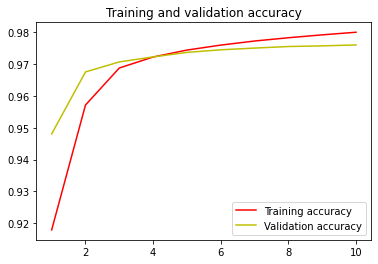

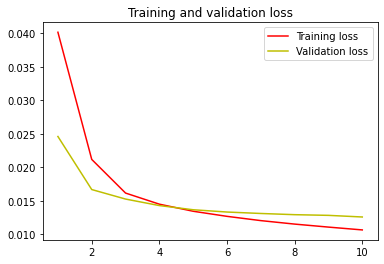

<Figure size 432x288 with 0 Axes>

In [26]:
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_training = range(1, len(acc)+1)

plt.plot(epochs_training, acc, 'r', label='Training accuracy')
plt.plot(epochs_training, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs_training, loss, 'r', label='Training loss')
plt.plot(epochs_training, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()

In [27]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_tokens = val_tokens[:500*32]
test_pred = model.predict(np.array(test_tokens), verbose=1)

idx2tag_ = {i: w for w, i in tag2idx.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            # print(p_i)
            out_i.append(idx2tag_[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            # print(p)
            p_i = np.argmax(p)
            out_i.append(idx2tag_[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(val_tags[:500*32])
print(classification_report(test_labels, pred_labels))
# pred_labels

500/500 [==============================] - 25s 48ms/step
              precision    recall  f1-score   support

          OI       0.61      0.63      0.62      6755
       treet       0.73      0.78      0.75     12783

   micro avg       0.69      0.73      0.71     19538
   macro avg       0.67      0.71      0.69     19538
weighted avg       0.69      0.73      0.71     19538



In [28]:
i = 5000
batch_size = 32

p = model.predict(np.array(val_tokens[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(val_tokens[i], val_tags[i], p):
    true = np.argmax(true)
    if w != "__PAD__":
        print("{:15}:{:5} ({})".format(idx2token.get(w), idx2tag.get(pred), idx2tag.get(true)))
        # print(pred)


Word            Pred : (True)
sudi           :street (street)
ayam           :POI   (POI)
penyet         :POI   (POI)
h              :POI   (POI)
dullah         :O     (POI)
mandau         :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)
ktc            :O     (O)


#Evaluate and Test

In [29]:
testset = pd.read_csv("/content/test.csv")
testset

import string

table = str.maketrans('', '', string.punctuation)
test_address_array = []
for index, row in testset.iterrows():
    stripped = [w.translate(table) for w in row['raw_address'].split()]
    test_address_array.append(stripped)
    
testset['address_array'] = test_address_array
testset

,id,raw_address,address_array
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]"
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karanganyar]"
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]"
...,...,...,...
49995,49995,toko mbak farid semboro semboro,"[toko, mbak, farid, semboro, semboro]"
49996,49996,"vie - tk. ridho kids, vete 3 cari, 16720 ciawi","[vie, , tk, ridho, kids, vete, 3, cari, 16720, ciawi]"
49997,49997,"mart dan roti bakar malabar, nasio,","[mart, dan, roti, bakar, malabar, nasio]"
49998,49998,graha indah pamulang jl. mujair raya bambu apus blok. b3 no. 11,"[graha, indah, pamulang, jl, mujair, raya, bambu, apus, blok, b3, no, 11]"


In [30]:
address_idx = []
for index, row in testset.iterrows():
    address_idx.append(list(map(token2idx.get, row['address_array'])))

address_idx_temp = []
for row in address_idx:
    address_idx_temp.append([0 if i == None else i for i in row])

testset['address_idx'] = address_idx_temp
testset

,id,raw_address,address_array,address_idx
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]","[82940, 51234, 48875, 5295, 52659, 45289, 97981]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]","[62187, 54396, 16664, 40625, 46130, 47762, 17438]"
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]","[84093, 39397, 15835, 82744]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karanganyar]","[44489, 41139, 92108, 17818, 4280, 23141, 94561, 1781]"
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]","[55880, 49514, 89355, 54542]"
...,...,...,...,...
49995,49995,toko mbak farid semboro semboro,"[toko, mbak, farid, semboro, semboro]","[56567, 67113, 67226, 78192, 78192]"
49996,49996,"vie - tk. ridho kids, vete 3 cari, 16720 ciawi","[vie, , tk, ridho, kids, vete, 3, cari, 16720, ciawi]","[72503, 0, 14367, 5332, 84189, 85130, 68152, 49920, 75946, 93815]"
49997,49997,"mart dan roti bakar malabar, nasio,","[mart, dan, roti, bakar, malabar, nasio]","[21454, 14535, 20041, 55904, 6106, 61861]"
49998,49998,graha indah pamulang jl. mujair raya bambu apus blok. b3 no. 11,"[graha, indah, pamulang, jl, mujair, raya, bambu, apus, blok, b3, no, 11]","[49494, 40625, 54915, 31044, 81644, 17818, 41074, 33606, 29248, 84791, 72955, 17053]"


In [31]:
temp = []
for i in testset['address_array'].to_list():
    temp.extend(list(set(i)))
n_token = len(list(set(temp)))

# n_tag = len(list(set(data_group['Tag'].to_list())))

#Pad tokens (X var)    
tokens = testset['address_idx'].tolist()
maxlen = max([len(s) for s in tokens])
test_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

In [32]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_tokens = test_tokens
test_pred = model.predict(np.array(test_tokens), verbose=1)

idx2tag_ = {i: w for w, i in tag2idx.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            # print(p_i)
            out_i.append(idx2tag_[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            # print(p)
            p_i = np.argmax(p)
            out_i.append(idx2tag_[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(test_tokens)
print(classification_report(test_labels, pred_labels))
# pred_labels

1563/1563 [==============================] - 57s 36ms/step
              precision    recall  f1-score   support

          OI       0.00      0.00      0.00         0
       treet       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



In [33]:
testset['pred_tag'] = pred_labels
testset

,id,raw_address,address_array,address_idx,pred_tag
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]","[82940, 51234, 48875, 5295, 52659, 45289, 97981]","[street, street, O, O, O, O, O, POI, POI, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]","[62187, 54396, 16664, 40625, 46130, 47762, 17438]","[street, street, O, O, O, O, O, O, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]","[84093, 39397, 15835, 82744]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karanganyar]","[44489, 41139, 92108, 17818, 4280, 23141, 94561, 1781]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]","[55880, 49514, 89355, 54542]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...,...,...,...
49995,49995,toko mbak farid semboro semboro,"[toko, mbak, farid, semboro, semboro]","[56567, 67113, 67226, 78192, 78192]","[O, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
49996,49996,"vie - tk. ridho kids, vete 3 cari, 16720 ciawi","[vie, , tk, ridho, kids, vete, 3, cari, 16720, ciawi]","[72503, 0, 14367, 5332, 84189, 85130, 68152, 49920, 75946, 93815]","[O, O, POI, POI, POI, street, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
49997,49997,"mart dan roti bakar malabar, nasio,","[mart, dan, roti, bakar, malabar, nasio]","[21454, 14535, 20041, 55904, 6106, 61861]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
49998,49998,graha indah pamulang jl. mujair raya bambu apus blok. b3 no. 11,"[graha, indah, pamulang, jl, mujair, raya, bambu, apus, blok, b3, no, 11]","[49494, 40625, 54915, 31044, 81644, 17818, 41074, 33606, 29248, 84791, 72955, 17053]","[POI, POI, O, street, street, street, O, O, O, O, O, O, O, POI, O, O, O, O, O, O, O, O, O, O, O]"


#Create Submission

In [34]:
table = str.maketrans('', '', string.punctuation)
test_address_array = []
for index, row in testset.iterrows():
    adrr = row['raw_address'].replace(',', '')
    stripped = adrr.split()
    test_address_array.append(stripped)

testset['address_array'] = test_address_array

In [35]:
pred_street = []
pred_POI_Street = []
for index, row in testset.iterrows():
    temp_street = []
    temp_POI = []
    length = len(row['address_array'])
    for i in range(length):
        if row['pred_tag'][i] == 'street':
            temp_street.append(row['address_array'][i])
        if row['pred_tag'][i] == 'POI':
            temp_POI.append(row['address_array'][i])
    street = ' '.join(temp_street)
    POI = ' '.join(temp_POI)
    pred_POI_Street.append(POI+'/'+street)

In [36]:
testset['POI/street'] = pred_POI_Street
testset

,id,raw_address,address_array,address_idx,pred_tag,POI/street
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s., par, 53, sidanegara, 4, cilacap, tengah]","[82940, 51234, 48875, 5295, 52659, 45289, 97981]","[street, street, O, O, O, O, O, POI, POI, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/s. par
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel., lubuk, baja]","[62187, 54396, 16664, 40625, 46130, 47762, 17438]","[street, street, O, O, O, O, O, O, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/angg per
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]","[84093, 39397, 15835, 82744]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karanganyar]","[44489, 41139, 92108, 17818, 4280, 23141, 94561, 1781]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]","[55880, 49514, 89355, 54542]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/
...,...,...,...,...,...,...
49995,49995,toko mbak farid semboro semboro,"[toko, mbak, farid, semboro, semboro]","[56567, 67113, 67226, 78192, 78192]","[O, POI, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",mbak/
49996,49996,"vie - tk. ridho kids, vete 3 cari, 16720 ciawi","[vie, -, tk., ridho, kids, vete, 3, cari, 16720, ciawi]","[72503, 0, 14367, 5332, 84189, 85130, 68152, 49920, 75946, 93815]","[O, O, POI, POI, POI, street, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",tk. ridho kids/vete
49997,49997,"mart dan roti bakar malabar, nasio,","[mart, dan, roti, bakar, malabar, nasio]","[21454, 14535, 20041, 55904, 6106, 61861]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",/
49998,49998,graha indah pamulang jl. mujair raya bambu apus blok. b3 no. 11,"[graha, indah, pamulang, jl., mujair, raya, bambu, apus, blok., b3, no., 11]","[49494, 40625, 54915, 31044, 81644, 17818, 41074, 33606, 29248, 84791, 72955, 17053]","[POI, POI, O, street, street, street, O, O, O, O, O, O, O, POI, O, O, O, O, O, O, O, O, O, O, O]",graha indah/jl. mujair raya


In [37]:
testset_temp = testset.copy()
submission = testset.drop(['raw_address', 'address_array', 'address_idx', 'pred_tag'], axis=1)

In [38]:
submission

,id,POI/street
0,0,/s. par
1,1,/angg per
2,2,/
3,3,/
4,4,/
...,...,...
49995,49995,mbak/
49996,49996,tk. ridho kids/vete
49997,49997,/
49998,49998,graha indah/jl. mujair raya


In [39]:
submission.to_csv('/content/submission.csv', header=True, index=False)

#Save Model H5

In [41]:
model.save("/content/address-extraction-shopee-code-league-2021-NER-test.h5")